# Constitution des jeux de données pour le Challenge de la Data party 
# *Les 30 ans de la MTD*

# Hal : les métadonnées des articles scientifiques


In [138]:
# Paramètres

collections_hal = ["TETIS", "ESPACE-DEV"]

# Hal : métadonnées récupérées

Plus d'information sur la documentation de l'API : https://api.archives-ouvertes.fr/docs/search/?schema=field-types#field-types

| Champ                | Description                                           |
| -------------------- | ----------------------------------------------------- |
| docid                | Identifiant du document dans la base de données HAL.   |
| halId_s              | Identifiant HAL unique associé au document.            |
| title_s              | Titre du document.                                     |
| authFullName_s       | Noms complets des auteurs.                             |
| authOrganismId_i     | ID des organismes.                                     |
| authOrganism_s       | Nom des affiliations.                                  |
| structCountry_s      | Code à 2 lettres des pays des auteurs                  |
| structAddress_s      | Adresses postal des auteurs                            |
| domainAllCode_s      | Thématique                                             |
| submittedDate_s      | Date de soumission du document.                        |
| abstract_s           | Résumé du document.                                    |
| journalDate_s        | Date de publication dans le journal.                   |
| publicationDate_s    | Date de publication du document.                       |
| producedDate_s       | Date de production du document.                        |
| docType_s            | Type de document (ART pour article, COUV pour couverture, etc.). |
| doiId_s              | Identifiant DOI associé au document.                   |
| journalPublisher_s   | Éditeur du journal dans lequel le document a été publié. |
| journalTitle_s       | Titre du journal dans lequel le document a été publié.  |
| journalIssn_s        | ISSN du journal dans lequel le document a été publié.   |
| researchData_s       | Identifiants (DOI) des données de recherche associées.  |
| docSubType_s         | Sous doc type: data paper, preprint, ...               |

In [139]:
my_lab = "TETIS"
#my_lab = "ESPACE-DEV"

In [140]:
import requests
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("pastel")
import matplotlib.pyplot as plt


hal_collection_url = f"https://api.archives-ouvertes.fr/search/{my_lab}"
# free_text_search = "geonlplify"
free_text_search = "*"
hal_api_params = {
    'q': f"{free_text_search}", #free text search
    "wt":"json", # format de sortie
    "fl": "docid,halId_s,title_s,authFullName_s,authOrganismId_i,authOrganism_s,structCountry_s,structAddress_s,domainAllCode_s,submittedDate_s,abstract_s,journalDate_s,publicationDate_s, producedDate_s, docType_s, doiId_s, journalPublisher_s, journalTitle_s, journalIssn_s, researchData_s, docSubType_s", # champs retournés
    "sort": "submittedDate_s desc",
    'rows': 5000, # nombre de documents récupérés sans pagination

}
reponse = requests.get(hal_collection_url, params=hal_api_params)

df = pd.DataFrame(reponse.json()["response"]["docs"])
df["submittedDate_s"] = pd.to_datetime(df["submittedDate_s"])
df["journalDate_s"] = pd.to_datetime(df["journalDate_s"])
# df["publicationDate_s"] = pd.to_datetime(df["publicationDate_s"], format='mixed')
df["producedDate_s"] = pd.to_datetime(df["producedDate_s"])

In [141]:
df.iloc[10]

docid                                                           4687421
domainAllCode_s                                                   [sde]
title_s               [Detection and Mapping of Cover Crops Using Se...
abstract_s            [Cover crops are intermediary crops planted in...
journalTitle_s        IEEE Journal of Selected Topics in Applied Ear...
journalPublisher_s                                                 IEEE
journalIssn_s                                                 1939-1404
journalDate_s                                       2020-10-30 18:31:06
authFullName_s        [Sami Najem, Nicolas Baghdadi, Hassan Bazzi, N...
authOrganismId_i                                                    NaN
authOrganism_s                                                      NaN
structAddress_s       [Maison de la télédétection - 500 rue Jean-Fra...
structCountry_s            [fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr]
halId_s                                                    hal-0

Text(0, 0.5, 'Nombre de contributions')

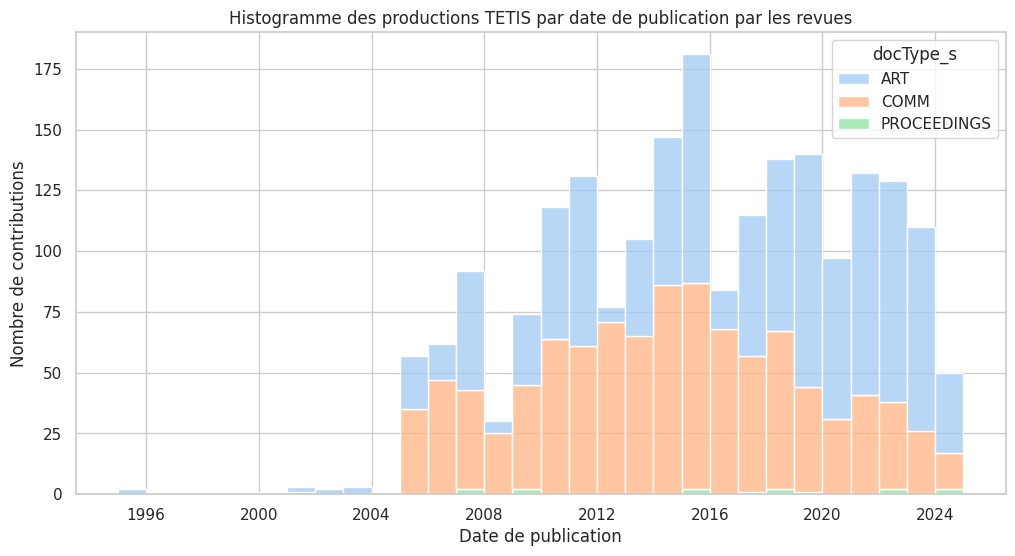

In [142]:
plt.figure(figsize=(12, 6))
selected_publication_types = ["ART", "COMM", "PROCEEDINGS"]
df_filtered = df[df['docType_s'].isin(selected_publication_types)]
#df_filtered = df_filtered[df_filtered['journalDate_s'] >= '2018-01-01']
sns.histplot(data=df_filtered, x="producedDate_s", stat="count", binwidth=365.25, hue="docType_s", multiple="stack")
plt.title(f'Histogramme des productions {my_lab} par date de publication par les revues')
plt.xlabel('Date de publication')
plt.ylabel('Nombre de contributions')
#plt.xticks(rotation=45)

In [143]:
df_filtered["producedDate_s"].describe()

/home/rdecoupe/PycharmProjects/dataparty-30ans/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    2083
unique                    813
top       2006-01-01 00:00:00
freq                       58
first     1995-01-01 00:00:00
last      2024-11-25 00:00:00
Name: producedDate_s, dtype: object

Nous n'avons que les abréviations des noms des pays ou regions comme : `fr, nc, re, ...`, il nous faut les convertir en nom de pays.

Comme le champs de métadonnnées `structCountry_s` contient une liste d'abréviations, nous allons créer de nouvelles colonnes portant le nom `country_{n}` avec `{n}`, le numéro du pays

In [144]:
df["structCountry_s"]

0        [fr, fr, fr, fr, fr, gb, gb, gb, gb, gh, gb, gb]
1       [fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, f...
2       [fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, f...
3       [fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, f...
4                                [fr, fr, fr, fr, fr, tn]
                              ...                        
2834                 [fr, fr, fr, fr, fr, fr, fr, fr, fr]
2835                 [fr, fr, fr, fr, fr, fr, fr, fr, fr]
2836                 [fr, fr, fr, fr, fr, fr, fr, fr, fr]
2837    [fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, f...
2838                 [fr, fr, fr, fr, fr, fr, fr, fr, fr]
Name: structCountry_s, Length: 2839, dtype: object

In [145]:
import pycountry

country_mapping = {country.alpha_2.lower(): country.name for country in pycountry.countries}
df_country_mapping = pd.DataFrame(list(country_mapping.items()), columns=['country_code', 'country_name'])


In [146]:
def map_countries(countries):
    # Map each abbreviation to its full name using a list comprehension
    try:
        res = [country_mapping.get(country, country) for country in countries]
    except:
        res = [""]
    return res

df['country_full_names'] = df['structCountry_s'].apply(map_countries)

countries_expanded = pd.DataFrame(df['country_full_names'].tolist(), index=df.index)
countries_expanded.columns = [f'country_{i+1}' for i in range(countries_expanded.shape[1])]
df = pd.concat([df, countries_expanded], axis=1)
df.drop('country_full_names', axis=1, inplace=True)

In [147]:
df["country_10"]

0        Ghana
1       France
2       France
3       France
4         None
         ...  
2834      None
2835      None
2836      None
2837    France
2838      None
Name: country_10, Length: 2839, dtype: object

In [151]:
df.to_csv(f"./../data/hal_export_{my_lab}.csv")